In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("ETEtotal_merged_reviewsfinal.csv")
df = df.drop("Name",axis=1)
df.head()

,Rating,Review
0,5.0,I visited Kebabs & Curries with a non-vegetari...
1,5.0,"In a city dominated by vegetarian food, this p..."
2,1.0,Im Athrv Joshi living in jaipur rajasthan 3020...
3,5.0,The place is good to go all the time for a qui...
4,5.0,Kebabs and curry serves the most authentic non...


In [2]:
import re
df['Review'] = df['Review'].str.lower()
df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
df.head()

,Rating,Review
0,5.0,i visited kebabs curries with a nonvegetarian...
1,5.0,in a city dominated by vegetarian food this pl...
2,1.0,im athrv joshi living in jaipur rajasthan whe...
3,5.0,the place is good to go all the time for a qui...
4,5.0,kebabs and curry serves the most authentic non...


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(df.head())
print(df['Rating'].value_counts())

   Rating                                             Review
0     5.0  i visited kebabs  curries with a nonvegetarian...
1     5.0  in a city dominated by vegetarian food this pl...
2     1.0  im athrv joshi living in jaipur rajasthan  whe...
3     5.0  the place is good to go all the time for a qui...
4     5.0  kebabs and curry serves the most authentic non...
Rating
5.0    588
4.0    278
1.0    186
3.0    156
2.0     58
Name: count, dtype: int64


In [4]:
tfidf = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    stop_words='english'
)
X = tfidf.fit_transform(df['Review'])  # or 'Review' if not preprocessed

# 5. Target: Adjust star ratings to 0–4 range
y = df['Rating'] - 1

# 6. Train/Test Split (stratify for class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Apply SMOTE on training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 2. Check class distribution before & after
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_res))

Before SMOTE: Counter({4.0: 470, 3.0: 222, 0.0: 149, 2.0: 125, 1.0: 46})
After SMOTE: Counter({4.0: 470, 0.0: 470, 2.0: 470, 3.0: 470, 1.0: 470})


In [6]:
# Train on balanced data
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf.fit(X_train_res, y_train_res)

# Predict on original test set (not resampled)
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

Accuracy: 0.7834645669291339
              precision    recall  f1-score   support

         0.0      0.919     0.919     0.919        37
         1.0      0.750     0.750     0.750        12
         2.0      0.588     0.645     0.615        31
         3.0      0.652     0.768     0.705        56
         4.0      0.886     0.788     0.834       118

    accuracy                          0.783       254
   macro avg      0.759     0.774     0.765       254
weighted avg      0.796     0.783     0.787       254



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


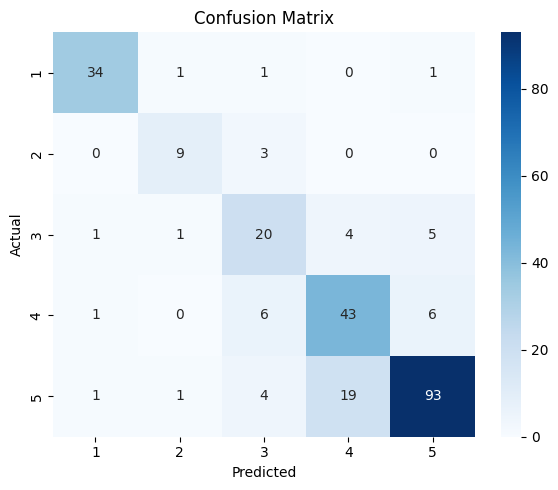

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [8]:
from sklearn.naive_bayes import MultinomialNB

# 1. Train Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_res, y_train_res)

# 2. Predict
y_pred_nb = nb_model.predict(X_test)

# 3. Evaluate
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, digits=3))


Naive Bayes Accuracy: 0.6771653543307087

Classification Report:
              precision    recall  f1-score   support

         0.0      0.758     0.676     0.714        37
         1.0      0.391     0.750     0.514        12
         2.0      0.405     0.548     0.466        31
         3.0      0.581     0.643     0.610        56
         4.0      0.904     0.720     0.802       118

    accuracy                          0.677       254
   macro avg      0.608     0.667     0.621       254
weighted avg      0.726     0.677     0.692       254



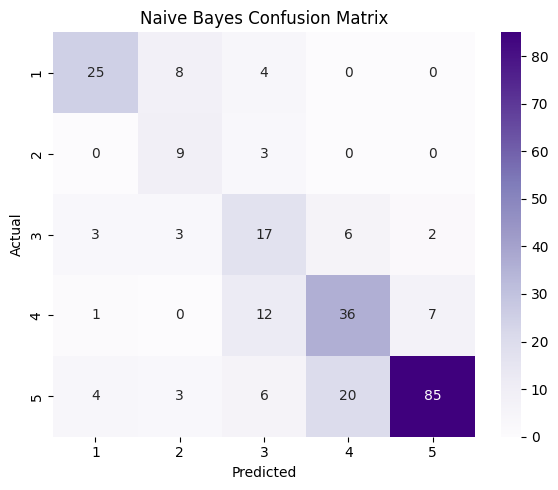

In [9]:

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes Confusion Matrix")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_res, y_train_res)

y_pred = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))


SVM Accuracy: 0.8267716535433071

Classification Report:
               precision    recall  f1-score   support

         0.0      0.921     0.946     0.933        37
         1.0      0.818     0.750     0.783        12
         2.0      0.694     0.806     0.746        31
         3.0      0.714     0.804     0.756        56
         4.0      0.906     0.814     0.857       118

    accuracy                          0.827       254
   macro avg      0.811     0.824     0.815       254
weighted avg      0.836     0.827     0.829       254



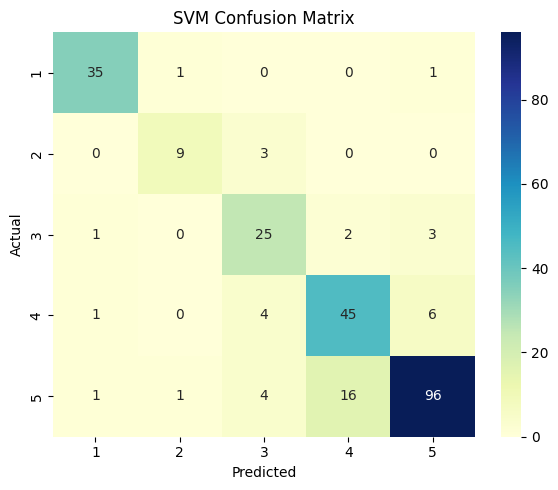

In [11]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.tight_layout()
plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

print("Random forrest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

Random forrest Accuracy: 0.8661417322834646

Classification Report:
               precision    recall  f1-score   support

         0.0      0.938     0.811     0.870        37
         1.0      1.000     0.667     0.800        12
         2.0      0.857     0.774     0.814        31
         3.0      0.870     0.839     0.855        56
         4.0      0.841     0.941     0.888       118

    accuracy                          0.866       254
   macro avg      0.901     0.806     0.845       254
weighted avg      0.871     0.866     0.865       254



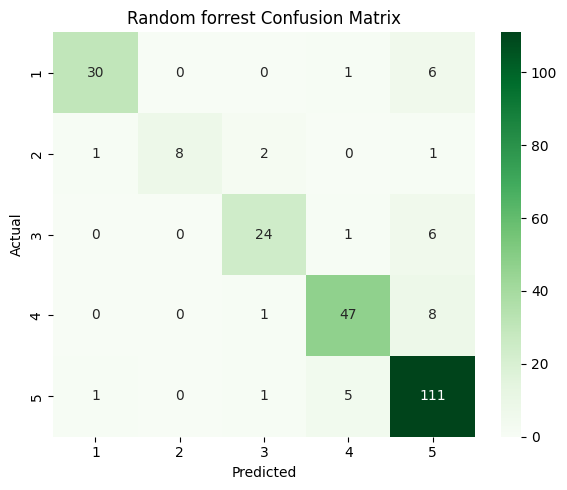

In [15]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random forrest Confusion Matrix")
plt.tight_layout()
plt.show()

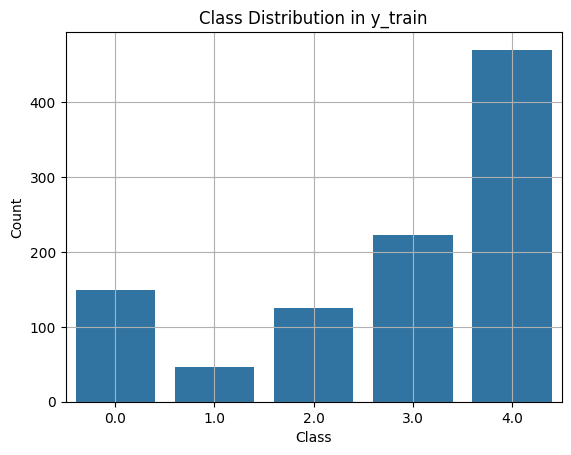

In [23]:
import seaborn as sns
import pandas as pd

sns.countplot(x=pd.Series(y_train))
plt.title('Class Distribution in y_train')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [27]:
new_reviews = ["good food!", "Worst experience ever."]
X_new = tfidf.transform(new_reviews)
preds = clf.predict(X_new)
print("Predicted ratings:", preds + 1)


Predicted ratings: [3. 1.]
